# ANALISI DEL SEGNALE 

In [26]:
#TODO Settare la frequenza di campionamento reale e non ipotetica
#%%time serve per calcolare il tempo di esecuzione della cella

Pre-Processing

In [27]:
%%time

globals().clear()
# (S04) Marco_D_G: cut at 2000 before interpolation
# (S06) Gianmarco_C_C: max_value - 1
# (S08) Sofia_P_F: max_value - 1
# (S08) Sofia_P_N: max_value - 1

static_f_threshold_max = 1 # Static, Cycling
walking_f_threshold_max = 0.75 #0.75
static_f_threshold_min = 0.05
walking_f_threshold_min = 0.2

f_threshold_min = walking_f_threshold_min
f_threshold_max = walking_f_threshold_max
start = 100
end = 2000

digit2voltage = 9/640  #value used to convert sample value to voltage

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import math
import matplotlib.pyplot as plt
import statistics
from pyquaternion import Quaternion
import numpy as np
import scipy.signal
from sklearn.decomposition import PCA
import scipy.stats as stats
#import tensorflow as ts  -- questo non serve!
import matplotlib.animation as animation

plt.rcParams.update({'figure.max_open_warning': 0})

data = pd.read_csv('Stefano_L_C.txt', sep=",|:", header=None, engine='python')

data.columns = ['TxRx', 'DevID', 'B', 'C', 'nthvalue', '1', '2', '3', '4', 'None']
# select only the Rx line
data = data.loc[data['TxRx'] == 'Rx']
data = data.drop(['TxRx', 'None'], axis=1)
data = data.reset_index(drop=True)  # reset the indexes order
# traforming into string in order to remove [ and ] from the file\
data['DevID'] = data['DevID'].astype(str)
data['DevID'] = data['DevID'].str.replace('[', '')
data['DevID'] = data['DevID'].str.replace(']', '')

data['B'] = data['B'].astype(str)
data['B'] = data['B'].str.replace('[', '')
data['B'] = data['B'].str.replace(']', '')

data['C'] = data['C'].astype(str)
data['C'] = data['C'].str.replace('[', '')
data['C'] = data['C'].str.replace(']', '')

data['nthvalue'] = data['nthvalue'].astype(str)
data['nthvalue'] = data['nthvalue'].str.replace('[', '')
data['nthvalue'] = data['nthvalue'].str.replace(']', '')

print(data)

     DevID   B   C nthvalue     1     2     3     4
0       03  00  00       01  [2b]  [4d]  [52]  [da]
1       02  00  00       01  [7a]  [f4]  [f6]  [e4]
2       03  00  00       01  [f3]  [30]  [74]  [06]
3       03  00  00       02  [f3]  [30]  [74]  [06]
4       01  00  00       02  [3e]  [e3]  [fc]  [6a]
...    ...  ..  ..      ...   ...   ...   ...   ...
6619    03  00  00       f7  [f4]  [09]  [7d]  [fc]
6620    01  00  00       be  [ef]  [ef]  [e8]  [7a]
6621    02  00  00       8a  [77]  [f8]  [f8]  [d7]
6622    03  00  00       f8  [f4]  [09]  [7d]  [fc]
6623    01  00  00       bf  [ef]  [ef]  [e8]  [7a]

[6624 rows x 8 columns]
Wall time: 371 ms


In [28]:
%%time 
data['1'] = data['1'].astype(str)
data['1'] = data['1'].str.replace('[', '')
data['1'] = data['1'].str.replace(']', '')

data['2'] = data['2'].astype(str)
data['2'] = data['2'].str.replace('[', '')
data['2'] = data['2'].str.replace(']', '')

data['3'] = data['3'].astype(str)
data['3'] = data['3'].str.replace('[', '')
data['3'] = data['3'].str.replace(']', '')

data['4'] = data['4'].astype(str)
data['4'] = data['4'].str.replace('[', '')
data['4'] = data['4'].str.replace(']', '')

data_1 = data[data['DevID'].str.contains('01')]  # thoracic data
data_1 = data_1.reset_index(drop=True)

data_2 = data[data['DevID'].str.contains('02')]  # abdominal data
data_2 = data_2.reset_index(drop=True)

data_3 = data[data['DevID'].str.contains('03')]  # reference data
data_3 = data_3.reset_index(drop=True)

Wall time: 50 ms


# Extract battery voltage

In [29]:
voltage_1 = data_1[['nthvalue','B']].copy()
voltage_2 = data_2[['nthvalue','B']].copy()
voltage_3 = data_3[['nthvalue','B']].copy()
voltage_1['B'] = voltage_1['B'].apply(int, base=16) * digit2voltage
voltage_2['B'] = voltage_2['B'].apply(int, base=16) * digit2voltage
voltage_3['B'] = voltage_3['B'].apply(int, base=16) * digit2voltage

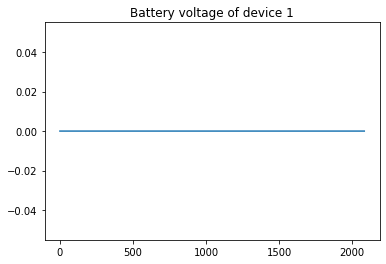

In [30]:
plt.title('Battery voltage of device 1')
plt.plot(voltage_1['B'])
tr=1

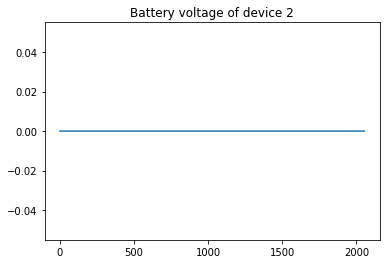

In [31]:
plt.title('Battery voltage of device 2')
plt.plot(voltage_2['B'])
tr=1

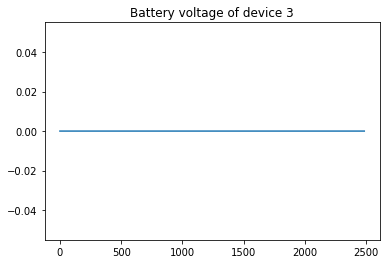

In [32]:
plt.title('Battery voltage of device 3')
plt.plot(voltage_3['B'])
tr=1

In [33]:
%%time
# nth reception and information transmitted
data_1 = data_1[data_1.columns[3:8]].copy()
data_2 = data_2[data_2.columns[3:8]].copy()
data_3 = data_3[data_3.columns[3:8]].copy()
#max value computation to have the number of 256-value blocks
#if len(data_3) >= len(data_1):
#    if len(data_3) >= len(data_2):
#        max_value = math.floor((len(data_3)) / 256)
#    else:
#        max_value = math.floor((len(data_2)) / 256)
#else:
#    if len(data_1) >= len(data_2):
#        max_value = math.floor((len(data_1)) / 256)
#    else:
#        max_value = math.floor((len(data_2)) / 256)

print("Numero di campioni acquisiti da unita' 1: ", len(data_1))
print("Numero di campioni acquisiti da unita' 2: ", len(data_2))
print("Numero di campioni acquisiti da unita' 3: ", len(data_3))

if len(data_3) > len(data_1) and len(data_3) > len(data_2):
    max_value = math.floor(len(data_3) / 256)
    #max_value = math.ceil(len(data_3) / 256)
elif len(data_1) > len(data_2) and len(data_1) > len(data_3):
    max_value = math.floor(len(data_1) / 256)
    #max_value = math.ceil(len(data_1) / 256)
else:
    max_value = math.floor((len(data_2)) / 256)
    #max_value = math.ceil(len(data_2) / 256)
print("Ho", max_value,"blocchi da 256 campioni")
# conversion from hexadecimal to decimal
data_1['nthvalue'] = data_1['nthvalue'].apply(int, base=16)
data_2['nthvalue'] = data_2['nthvalue'].apply(int, base=16)
data_3['nthvalue'] = data_3['nthvalue'].apply(int, base=16)

data_1['1'] = data_1['1'].apply(int, base=16)
data_2['1'] = data_2['1'].apply(int, base=16)
data_3['1'] = data_3['1'].apply(int, base=16)

data_1['2'] = data_1['2'].apply(int, base=16)
data_2['2'] = data_2['2'].apply(int, base=16)
data_3['2'] = data_3['2'].apply(int, base=16)

data_1['3'] = data_1['3'].apply(int, base=16)
data_2['3'] = data_2['3'].apply(int, base=16)
data_3['3'] = data_3['3'].apply(int, base=16)

data_1['4'] = data_1['4'].apply(int, base=16)
data_2['4'] = data_2['4'].apply(int, base=16)
data_3['4'] = data_3['4'].apply(int, base=16)

fdev = (max(len(data_1['1']),len(data_2['1']),len(data_3['1'])))/300
#print(fdev)

max_value=max_value-1  #perchè??
print(data_1)
print(data_2)
print(data_3)
#data_1.to_csv(r'C:\Users\Stefano\Desktop\Analisi del segnale\data1before.csv')

Numero di campioni acquisiti da unita' 1:  2083
Numero di campioni acquisiti da unita' 2:  2054
Numero di campioni acquisiti da unita' 3:  2487
Ho 9 blocchi da 256 campioni
      nthvalue    1    2    3    4
0            2   62  227  252  106
1            3   62  227  252  106
2            4   61  227  252  106
3            5   61  227  252  106
4            6   61  227  251  107
...        ...  ...  ...  ...  ...
2078       185  239  239  232  122
2079       188  239  239  232  122
2080       189  239  239  232  122
2081       190  239  239  232  122
2082       191  239  239  232  122

[2083 rows x 5 columns]
      nthvalue    1    2    3    4
0            1  122  244  246  228
1            4  122  243  245  228
2            5  122  243  246  228
3            6  122  243  246  228
4            7  122  243  247  228
...        ...  ...  ...  ...  ...
2049       134  119  248  248  216
2050       135  119  248  248  216
2051       136  119  248  248  215
2052       137  119  248  248  2

# Add an empty row when there is a "jump" in communication, when the nth value is not received

In [34]:
%%time
for i in range(max_value):
    for j in range(256):
        if data_1['nthvalue'][j + i * 256] != j:
            empty_row = pd.DataFrame([], index=[j + i * 256])  # creating the empty row
            data_1 = pd.concat([data_1.loc[:j + i * 256 - 1], empty_row, data_1.loc[j + i * 256:]])
            #print(i)
            data_1 = data_1.reset_index(drop=True)
            
print(data_1)
#data_1.to_csv(r'C:\Users\Stefano\Desktop\Analisi del segnale\data1after.csv')
data_1 = data_1.iloc[:max_value * 256]
#data_1.to_csv(r'C:\Users\Stefano\Desktop\Analisi del segnale\data1afteriloc.csv')
print(data_1)  #Numero di righe: (max_value-1)*256


for i in range(max_value):
    for j in range(256):
        if data_2['nthvalue'][j + i * 256] != j:
            empty_row = pd.DataFrame([], index=[j + i * 256])  # creating the empty data
            data_2 = pd.concat([data_2.loc[:j + i * 256 - 1], empty_row, data_2.loc[j + i * 256:]])
            data_2 = data_2.reset_index(drop=True)

data_2 = data_2.iloc[:max_value * 256]

for i in range(max_value):
    for j in range(256):
        if data_3['nthvalue'][j + i * 256] != j:
            empty_row = pd.DataFrame([], index=[j + i * 256])  # creating the empty data
            data_3 = pd.concat([data_3.loc[:j + i * 256 - 1], empty_row, data_3.loc[j + i * 256:]])
            data_3 = data_3.reset_index(drop=True)

data_3 = data_3.iloc[:max_value * 256]

      nthvalue      1      2      3      4
0          NaN    NaN    NaN    NaN    NaN
1          NaN    NaN    NaN    NaN    NaN
2          2.0   62.0  227.0  252.0  106.0
3          3.0   62.0  227.0  252.0  106.0
4          4.0   61.0  227.0  252.0  106.0
...        ...    ...    ...    ...    ...
2427     185.0  239.0  239.0  232.0  122.0
2428     188.0  239.0  239.0  232.0  122.0
2429     189.0  239.0  239.0  232.0  122.0
2430     190.0  239.0  239.0  232.0  122.0
2431     191.0  239.0  239.0  232.0  122.0

[2432 rows x 5 columns]
      nthvalue      1      2      3      4
0          NaN    NaN    NaN    NaN    NaN
1          NaN    NaN    NaN    NaN    NaN
2          2.0   62.0  227.0  252.0  106.0
3          3.0   62.0  227.0  252.0  106.0
4          4.0   61.0  227.0  252.0  106.0
...        ...    ...    ...    ...    ...
2043     251.0  241.0  241.0  231.0  122.0
2044     252.0  241.0  241.0  231.0  122.0
2045       NaN    NaN    NaN    NaN    NaN
2046     254.0  240.0  241.0 

# Quaternion rebuild in range [-1;1]

In [35]:
%%time
quat1_1 = data_1['1']
for i in range(len(quat1_1)):
    if quat1_1[i] > 127:
        quat1_1[i] = quat1_1[i] - 256
quat1_1 = quat1_1 / 127

quat1_2 = data_1['2']
for i in range(len(quat1_2)):
    if quat1_2[i] > 127:
        quat1_2[i] = quat1_2[i] - 256
quat1_2 = quat1_2 / 127

quat1_3 = data_1['3']
for i in range(len(quat1_3)):
    if quat1_3[i] > 127:
        quat1_3[i] = quat1_3[i] - 256
quat1_3 = quat1_3 / 127

quat1_4 = data_1['4']
for i in range(len(quat1_4)):
    if quat1_4[i] > 127:
        quat1_4[i] = quat1_4[i] - 256
quat1_4 = quat1_4 / 127

quat2_1 = data_2['1']
for i in range(len(quat2_1)):
    if quat2_1[i] > 127:
        quat2_1[i] = quat2_1[i] - 256
quat2_1 = quat2_1 / 127

quat2_2 = data_2['2']
for i in range(len(quat2_2)):
    if quat2_2[i] > 127:
        quat2_2[i] = quat2_2[i] - 256
quat2_2 = quat2_2 / 127

quat2_3 = data_2['3']
for i in range(len(quat2_3)):
    if quat2_3[i] > 127:
        quat2_3[i] = quat2_3[i] - 256
quat2_3 = quat2_3 / 127

quat2_4 = data_2['4']
for i in range(len(quat2_4)):
    if quat2_4[i] > 127:
        quat2_4[i] = quat2_4[i] - 256
quat2_4 = quat2_4 / 127

quat3_1 = data_3['1']
for i in range(len(quat3_1)):
    if quat3_1[i] > 127:
        quat3_1[i] = quat3_1[i] - 256
quat3_1 = quat3_1 / 127

quat3_2 = data_3['2']
for i in range(len(quat3_2)):
    if quat3_2[i] > 127:
        quat3_2[i] = quat3_2[i] - 256
quat3_2 = quat3_2 / 127

quat3_3 = data_3['3']
for i in range(len(quat3_3)):
    if quat3_3[i] > 127:
        quat3_3[i] = quat3_3[i] - 256
quat3_3 = quat3_3 / 127

quat3_4 = data_3['4']
for i in range(len(quat3_4)):
    if quat3_4[i] > 127:
        quat3_4[i] = quat3_4[i] - 256
quat3_4 = quat3_4 / 127
'''
plt.figure(1)
plt.plot(quat1_1, label="quat1_1")
plt.plot(quat1_2, label="quat1_2")
plt.plot(quat1_3, label="quat1_3")
plt.plot(quat1_4, label="quat1_4")
plt.ylim(-1, 1)
plt.legend(loc='upper right')

plt.figure(2)
plt.plot(quat2_1, label="quat2_1")
plt.plot(quat2_2, label="quat2_2")
plt.plot(quat2_3, label="quat2_3")
plt.plot(quat2_4, label="quat2_4")
plt.ylim(-1, 1)
plt.legend(loc='upper right')

plt.figure(3)
plt.plot(quat3_1, label="quat3_1")
plt.plot(quat3_2, label="quat3_2")
plt.plot(quat3_3, label="quat3_3")
plt.plot(quat3_4, label="quat3_4")
plt.ylim(-1, 1)
plt.legend(loc='upper right')

plt.figure(4)
plt.plot(quat1_1, label="quat1_1")
plt.plot(quat2_1, label="quat2_1")
plt.plot(quat3_1, label="quat3_1")
plt.ylim(-1, 1)
plt.legend(loc='upper right')
plt.title('q1')

plt.figure(5)
plt.plot(quat1_2, label="quat1_2")
plt.plot(quat2_2, label="quat2_2")
plt.plot(quat3_2, label="quat3_2")
plt.ylim(-1, 1)
plt.legend(loc='upper right')
plt.title('q2')

plt.figure(6)
plt.plot(quat1_3, label="quat1_3")
plt.plot(quat2_3, label="quat2_3")
plt.plot(quat3_3, label="quat3_3")
plt.ylim(-1, 1)
plt.legend(loc='upper right')
plt.title('q3')

plt.figure(7)
plt.plot(quat1_4, label="quat1_4")
plt.plot(quat2_4, label="quat2_4")
plt.plot(quat3_4, label="quat3_4")
plt.ylim(-1, 1)
plt.legend(loc='upper right')
plt.title('q4')

'''
tor = {'quat1_1': quat1_1, 'quat1_2': quat1_2, 'quat1_3': quat1_3, 'quat1_4': quat1_4}
tor = pd.DataFrame(tor)
abd = {'quat2_1': quat2_1, 'quat2_2': quat2_2, 'quat2_3': quat2_3, 'quat2_4': quat2_4}
abd = pd.DataFrame(abd)
ref = {'quat3_1': quat3_1, 'quat3_2': quat3_2, 'quat3_3': quat3_3, 'quat3_4': quat3_4}
ref = pd.DataFrame(ref)
#tor.to_csv(r'C:\Users\Stefano\Desktop\Analisi del segnale\torquat.csv')

Wall time: 1.26 s


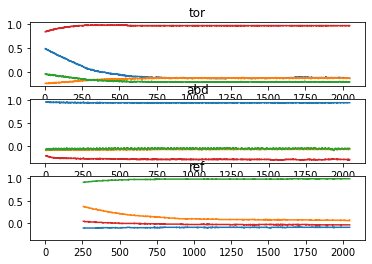

In [36]:
#PLOT DEI QUATERNIONI
plt.figure(8)
plt.subplot(3, 1, 1)
plt.plot(tor)
plt.title('tor')
plt.subplot(3, 1, 2)
plt.plot(abd)
plt.title('abd')
plt.subplot(3, 1, 3)
plt.plot(ref)
plt.title('ref')
tr=1 #sopprime un errore strano

In [37]:
%%time
# Replacing Nan with interpolation
tor.interpolate(method='pchip', inplace=True)
abd.interpolate(method='pchip', inplace=True)
ref.interpolate(method='pchip', inplace=True)

# tor.interpolate(method='spline', order=3, inplace=True) or method='nearest'
# abd.interpolate(method='spline', order=3, inplace=True)
# ref.interpolate(method='spline', order=3, inplace=True)

tor = tor.loc[1:]
tor.fillna(method='bfill', inplace=True)
tor = tor.reset_index(drop=True)
abd = abd.loc[1:]
abd.fillna(method='bfill', inplace=True)
abd = abd.reset_index(drop=True)
ref = ref.loc[1:]
ref.fillna(method='bfill', inplace=True)
ref = ref.reset_index(drop=True)

print(tor)
#tor.to_csv(r'C:\Users\Stefano\Desktop\Analisi del segnale\torquatinterpol.csv')

       quat1_1   quat1_2   quat1_3   quat1_4
0     0.488189 -0.228346 -0.031496  0.834646
1     0.488189 -0.228346 -0.031496  0.834646
2     0.488189 -0.228346 -0.031496  0.834646
3     0.480315 -0.228346 -0.031496  0.834646
4     0.480315 -0.228346 -0.031496  0.834646
...        ...       ...       ...       ...
2042 -0.118110 -0.118110 -0.196850  0.960630
2043 -0.118110 -0.118110 -0.196850  0.960630
2044 -0.122047 -0.118110 -0.196850  0.960630
2045 -0.125984 -0.118110 -0.196850  0.960630
2046 -0.125984 -0.118110 -0.196850  0.960630

[2047 rows x 4 columns]
Wall time: 19 ms


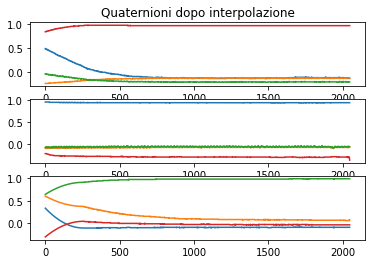

In [38]:
# pose window selection

plt.figure(9)
plt.subplot(3, 1, 1)
plt.plot(tor)
plt.title('Quaternioni dopo interpolazione')
plt.subplot(3, 1, 2)
plt.plot(abd)
plt.subplot(3, 1, 3)
plt.plot(ref)

tr=1

In [39]:
%%time
#interval_tor = (tor.loc[start_1:end_1])
#interval_tor = (tor.loc[start:end])
interval_tor = tor
tor_pose_w = [statistics.mean(interval_tor['quat1_1']), statistics.mean(interval_tor['quat1_2']),
              statistics.mean(interval_tor['quat1_3']), statistics.mean(interval_tor['quat1_4'])]

#interval_abd = (abd.loc[start_1:end_1])
interval_abd = (abd.loc[start:end])
abd_pose_w = [statistics.mean(interval_abd['quat2_1']), statistics.mean(interval_abd['quat2_2']),
              statistics.mean(interval_abd['quat2_3']), statistics.mean(interval_abd['quat2_4'])]

#interval_ref = (ref.loc[start_1:end_1])
interval_ref = (ref.loc[start:end])
ref_pose_w = [statistics.mean(interval_ref['quat3_1']), statistics.mean(interval_ref['quat3_2']),
              statistics.mean(interval_ref['quat3_3']), statistics.mean(interval_ref['quat3_4'])]


# Tor_pose = pd.DataFrame(columns=tor.columns)
# for i in range(len(tor)):
#    Tor_pose.loc[i] = tor_pose_w
Tor_pose = []
while len(Tor_pose) < len(tor):
    Tor_pose.append(tor_pose_w)
    
# Abd_pose = pd.DataFrame(columns=abd.columns)
# for i in range(len(abd)):
#    Abd_pose.loc[i] = abd_pose_w
Abd_pose = []
while len(Abd_pose) < len(abd):
    Abd_pose.append(abd_pose_w)

# Ref_pose = pd.DataFrame(columns=ref.columns)
# for i in range(len(ref)):
#    Ref_pose.loc[i] = ref_pose_w
Ref_pose = []
while len(Ref_pose) < len(ref):
    Ref_pose.append(ref_pose_w)
    
    
# array form to create the Quaternion
tor_array = tor.rename_axis().values
# Tor_pose_array = Tor_pose.rename_axis().values
tor_pose = pd.DataFrame(columns=['1', '2', '3', '4'])
for i in range(len(tor)):  # in pyQuaternion the quaternion are only elements 4x1, the product is performed row by row
    tor_quat = Quaternion(tor_array[i])
    Tor_pose_quat = Quaternion(Tor_pose[i])  # quaternion of the mean value
    tor_pose_row = tor_quat * Tor_pose_quat.conjugate  # quaternion product
    tor_pose.loc[i] = [tor_pose_row[0], tor_pose_row[1], tor_pose_row[2], tor_pose_row[3]]

print(tor_pose)    
abd_array = abd.rename_axis().values
# Abd_pose_array = Abd_pose.rename_axis().values
abd_pose = pd.DataFrame(columns=['1', '2', '3', '4'])
for i in range(len(abd)):
    abd_quat = Quaternion(abd_array[i])
    Abd_pose_quat = Quaternion(Abd_pose[i])
    abd_pose_row = abd_quat * Abd_pose_quat.conjugate
    abd_pose.loc[i] = [abd_pose_row[0], abd_pose_row[1], abd_pose_row[2], abd_pose_row[3]]

ref_array = ref.rename_axis().values
# Ref_pose_array = Ref_pose.rename_axis().values
ref_pose = pd.DataFrame(columns=['1', '2', '3', '4'])
for i in range(len(ref)):
    ref_quat = Quaternion(ref_array[i])
    Ref_pose_quat = Quaternion(Ref_pose[i])
    ref_pose_row = ref_quat * Ref_pose_quat.conjugate
    ref_pose.loc[i] = [ref_pose_row[0], ref_pose_row[1], ref_pose_row[2], ref_pose_row[3]]

             1         2         3         4
0     0.812467 -0.044498 -0.016109 -0.541383
1     0.812467 -0.044498 -0.016109 -0.541383
2     0.812467 -0.044498 -0.016109 -0.541383
3     0.812822 -0.045560 -0.017531 -0.533855
4     0.812822 -0.045560 -0.017531 -0.533855
...        ...       ...       ...       ...
2042  0.975256  0.004069  0.004218  0.074826
2043  0.975256  0.004069  0.004218  0.074826
2044  0.975433  0.003538  0.003507  0.078590
2045  0.975611  0.003007  0.002796  0.082354
2046  0.975611  0.003007  0.002796  0.082354

[2047 rows x 4 columns]
Wall time: 11 s


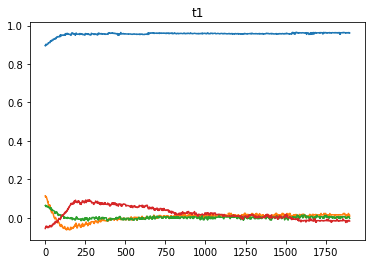

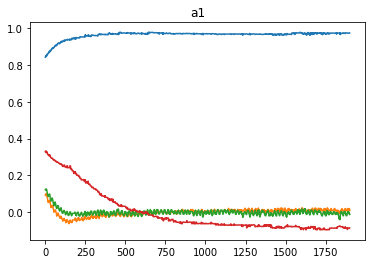

In [40]:
# selection of the window to be analyzed
'''plt.figure(10)
plt.subplot(3, 1, 1)
plt.plot(tor)
plt.title('Select window to analyze')
plt.subplot(3, 1, 2)
plt.plot(abd)
plt.subplot(3, 1, 3)
plt.plot(ref)
print('Please click to identify the start')
start_2 = plt.ginput(1)
start_2 = round(start_2[0][0])
# start_2 = 218
print('Please click to identify the end')
end_2 = plt.ginput(1)
end_2 = round(end_2[0][0])'''
# end_2 = 4665
#start_2 = 400

Tor_Ok = tor_pose.loc[start:end]
Abd_Ok = abd_pose.loc[start:end]
Ref_Ok = ref_pose.loc[start:end]

# Tor_Ok = tor_pose.loc[start_2:]
# Abd_Ok = abd_pose.loc[start_2:]
# Ref_Ok = ref_pose.loc[start_2:]

Tor_Ok_array = Tor_Ok.rename_axis().values
Ref_Ok_array = Ref_Ok.rename_axis().values
t1 = pd.DataFrame(columns=['1', '2', '3', '4'])
for i in range(len(Tor_Ok)):
    Tor_Ok_quat = Quaternion(Tor_Ok_array[i])
    Ref_Ok_quat = Quaternion(Ref_Ok_array[i])
    t1_row = Tor_Ok_quat * Ref_Ok_quat.conjugate  #thorax with respect to the reference
    t1.loc[i] = [t1_row[0], t1_row[1], t1_row[2], t1_row[3]]

Abd_Ok_array = Abd_Ok.rename_axis().values
Ref_Ok_array = Ref_Ok.rename_axis().values
a1 = pd.DataFrame(columns=['1', '2', '3', '4'])
for i in range(len(Abd_Ok)):
    Abd_Ok_quat = Quaternion(Abd_Ok_array[i])
    Ref_Ok_quat = Quaternion(Ref_Ok_array[i])
    a1_row = Abd_Ok_quat * Ref_Ok_quat.conjugate  #abdomen wrt reference
    a1.loc[i] = [a1_row[0], a1_row[1], a1_row[2], a1_row[3]]

#BASELINE COMPUTATION    
# moving average
N = 97
interp_T = t1.iloc[:, ].rolling(N, min_periods=49, center=True).mean()
interp_A = a1.iloc[:, ].rolling(N, min_periods=49, center=True).mean()

plt.figure(11)
plt.plot(t1)
plt.title('t1')
#
plt.figure(12)
plt.plot(a1)
plt.title('a1')

t1 = t1-interp_T  #THORACIC COMPONENT
a1 = a1-interp_A  #ABDOMINAL COMPONENT

# PCA: the first component is taken for both abdomen and thorax

Wall time: 513 ms


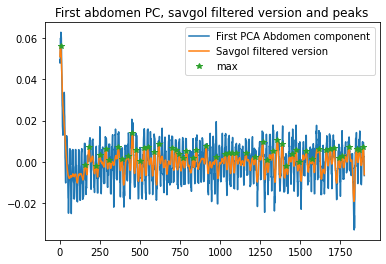

In [41]:
%%time
pca = PCA(n_components=1)  # pca = PCA(n_components=4)
FuseA_1 = pca.fit_transform(a1)  # FuseA_1 = pca.fit_transform(a1)[:,0]  FuseA_2 = pca.fit_transform(a1)[:,1] ...
FuseT_1 = pca.fit_transform(t1)
FuseT_1 = FuseT_1  # problema: rispetto a Matlab prende i segni opposti (direzione opposta), da togliere poi

SgolayWindowPCA = 31
#fdev = 10  # frequency of the device

# Abdomen
EstimSmoothA = scipy.signal.savgol_filter(np.ravel(FuseA_1), SgolayWindowPCA, 3)  # Savitzky-Golay filter application
diff_A = max(EstimSmoothA)-min(EstimSmoothA)
thr_A = diff_A*5/100

Index_A = scipy.signal.find_peaks(EstimSmoothA, distance=6, prominence=thr_A)  # find peaks
Index_A = Index_A[0]
fStimVec_A = []
for i in range(len(Index_A)-1):
    intrapeak = (Index_A[i + 1] - Index_A[i])/fdev  # interapeak distance is used to estimate the frequency
    fstim = 1 / intrapeak
    fStimVec_A.append(fstim)
fStimMean_A = statistics.mean(fStimVec_A)
fStimstd_A = statistics.stdev(fStimVec_A)
lowThreshold_A = max(f_threshold_min, (fStimMean_A-fStimstd_A))  # creation of the abdomen threshold
f_A, pxx_A = scipy.signal.welch(np.ravel(FuseA_1), fs=10, window='hamming',  nperseg=300, noverlap=50, nfft=512, detrend=False)  # PCA_1 abdomen spectrum (fA is the nomralized frequency vector).

plt.figure(13)
plt.plot(FuseA_1, label='First PCA Abdomen component')
plt.plot(EstimSmoothA, label='Savgol filtered version')
plt.plot(Index_A, EstimSmoothA[Index_A], linestyle='None', marker="*", label='max')
plt.title('First abdomen PC, savgol filtered version and peaks')
plt.legend(loc='upper right')
tr=1

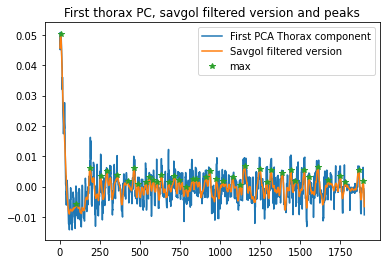

In [42]:
# Thorax
EstimSmoothT = scipy.signal.savgol_filter(np.ravel(FuseT_1), SgolayWindowPCA, 3)
diff_T = max(EstimSmoothT)-min(EstimSmoothT)
thr_T = diff_T*5/100

Index_T = scipy.signal.find_peaks(EstimSmoothT, distance=6, prominence=thr_T)
Index_T = Index_T[0]
fStimVec_T = []
for i in range(len(Index_T)-1):
    intrapeak = (Index_T[i + 1] - Index_T[i])/fdev
    fstim = 1 / intrapeak
    fStimVec_T.append(fstim)
fStimMean_T = statistics.mean(fStimVec_T)
fStimstd_T = statistics.stdev(fStimVec_T)
lowThreshold_T = max(f_threshold_min, (fStimMean_T-fStimstd_T))  # creation of the thorax threshold
f_T, pxx_T = scipy.signal.welch(np.ravel(FuseT_1), window='hamming', fs=10, nperseg=300, noverlap=50, nfft=512, detrend=False)  # %PCA_1 thoracic spectrum (fT is the nomralized frequency vector)

plt.figure(14)
plt.plot(FuseT_1, label='First PCA Thorax component')
plt.plot(EstimSmoothT, label='Savgol filtered version')
plt.plot(Index_T, EstimSmoothT[Index_T], linestyle='None', marker="*", label='max')
plt.title('First thorax PC, savgol filtered version and peaks')
plt.legend(loc='upper right')

lowThreshold = min(lowThreshold_A, lowThreshold_T)  # the low threshold is computed as the minimum between the thoracic and the abdominal one

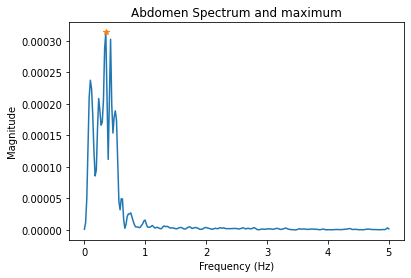

In [17]:
# Abdomen maxima and minima detection
Signal_A = -FuseA_1
start_A = np.where(f_A > lowThreshold)[0][0] - 1
end_A = np.where(f_A > f_threshold_max)[0][0]
fBmax_A = max(pxx_A[start_A:end_A])  # breathing frequency as the highest peak
fBI_A = np.where(pxx_A[start_A:end_A] == fBmax_A)[0][0]  # max (breathing frequency) postion

plt.figure(15)
plt.plot(f_A, pxx_A)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.plot(f_A[fBI_A+start_A], fBmax_A, marker='*')
plt.title('Abdomen Spectrum and maximum')

fBspectrum_A = f_A[fBI_A+start_A]  # value retrieved from position in f_A
f1 = max(f_threshold_min, fBspectrum_A-0.4)
f2 = min(fBspectrum_A+0.4,f_threshold_max)
# print(f1, f2)
# print('Low, high, abdomen')

ft_pl = f2
Wn_pl = ft_pl/(fdev/2)
b, a = scipy.signal.butter(1, 0.15, 'lowpass')  # low pass filter (Butterworth) b, a = scipy.signal.butter(1, Wn_pl, 'lowpass')
lowfilt_A = scipy.signal.filtfilt(b, a, np.ravel(Signal_A))

ft_ph = f1
Wn_ph = ft_ph/(fdev/2)
b, a = scipy.signal.butter(1, Wn_ph, 'highpass')  # high pass filter (the result is the bandpass filtered version)
bpfilt_A = scipy.signal.filtfilt(b, a, lowfilt_A)
# bandpass filter
# Wn = [Wn_pl, Wn_ph]
# b, a = scipy.signal.butter(1, Wn, 'bandpass')
# bp = scipy.signal.filtfilt(b, a, np.ravel(Signal_A))

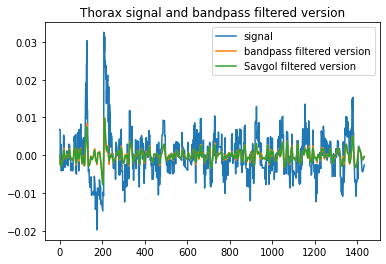

In [18]:
# parameters setting on empirical basis
if fBspectrum_A*60 < 12:
    perc_A = 15
    distance_A = 35  # min peak distance of 35 frames corresponds to a respiratory rate of 17 resp/min
    SgolayWindow = 15
elif 12 < fBspectrum_A*60 < 20:
#else:
    perc_A = 8
    distance_A = 20  # min peak distance of 20 frames corresponds to a respiratory rate of 30 resp/min
    SgolayWindow = 11
#elif 20 < fBspectrum_A*60 < 40:
else:
    perc_A = 5
    distance_A = 9  # min peak distance of 12 frames corresponds to a frequency rate of 50 resp/min
    SgolayWindow = 9
#else:
#elif 40 < fBspectrum_A*60 < 59:
#    perc_A = 4
#    distance_A = 7  # min peak distance of 8 frames correspondsto a respiratory rate of 75 resp/min
#    SgolayWindow = 7
#else:  # fBspectrum_A*60 > 59
#    perc_A = 3
#    distance_A = 3  # min peak distance of 5 frames corresponds to a respiratory rate of 120 resp/min
#    SgolayWindow = 5

SmoothSmoothA = scipy.signal.savgol_filter(bpfilt_A, SgolayWindow, 3)
diff_SSA = max(SmoothSmoothA)-min(SmoothSmoothA)
thr_SSA = diff_SSA*perc_A/100

# plt.figure(16)
# plt.plot(Signal_A, label='signal')
# plt.plot(bpfilt_A, label='bandpass filtered version')
# plt.plot(SmoothSmoothA, label='Savgol filtered version')
# plt.title('Abdomen signal and bandpass filtered version')
# plt.legend(loc='upper right')

Max_Ind_A = scipy.signal.find_peaks(SmoothSmoothA, distance=distance_A, prominence=thr_SSA)
Max_Ind_A = Max_Ind_A[0]
Maxima_A = SmoothSmoothA[Max_Ind_A]
Min_Ind_A = []
Minima_A = []
for i in range(len(Max_Ind_A)-1):
    min_value = min(SmoothSmoothA[Max_Ind_A[i]:Max_Ind_A[i+1]])
    Minima_A.append(min_value)
    min_index = np.argmin(SmoothSmoothA[Max_Ind_A[i]:Max_Ind_A[i+1]]) + Max_Ind_A[i]
    Min_Ind_A.append(min_index)

# plt.figure(17)
# plt.plot(SmoothSmoothA)
# plt.plot(Max_Ind_A, Maxima_A, linestyle='None',  marker='*')
# plt.plot(Min_Ind_A, Minima_A, linestyle='None',  marker='.')
# plt.title('Abdomen (Max-Min)')

# Respiratory parameters Abdomen
T_A = []
Ti_A = []
Te_A = []
TiTe_A = []
fB_A = []
for i in range(len(Min_Ind_A)):
    te = (Min_Ind_A[i] - Max_Ind_A[i]) / fdev
    ti = (Max_Ind_A[i + 1] - Min_Ind_A[i]) / fdev
    Ti_A.append(ti)
    Te_A.append(te)
    ti_te = ti/te
    TiTe_A.append(ti/te)
    ttot = ti + te
    fb = 1/ttot*60
    T_A.append(ttot)
    fB_A.append(fb)

Tmean_A = statistics.mean(T_A)
Timean_A = statistics.mean(Ti_A)
Temean_A = statistics.mean(Te_A)
fBmean_A = statistics.mean(fB_A)
fBspectrum_A = fBspectrum_A*60
TiTemean_A = statistics.mean(TiTe_A)
duty_mean_A = statistics.mean([float(Ti_A/T_A) for Ti_A, T_A in zip(Ti_A, T_A)])

Tstd_A = statistics.stdev(T_A)
Tistd_A = statistics.stdev(Ti_A)
Testd_A = statistics.stdev(Te_A)
fBstd_A = statistics.stdev(fB_A)
TiTestd_A = statistics.stdev(TiTe_A)
duty_std_A = statistics.stdev([float(Ti_A/T_A) for Ti_A, T_A in zip(Ti_A, T_A)])

PCA_A = [fBmean_A, Timean_A, Temean_A, TiTemean_A, duty_mean_A]
SD_A = [fBstd_A, Tistd_A, Testd_A, TiTestd_A, duty_std_A]

# Thorax maxima and minima detection
Signal_T = FuseT_1
start_T = np.where(f_T > lowThreshold)[0][0] - 1
end_T = np.where(f_T > f_threshold_max)[0][0]
fBmax_T = max(pxx_T[start_T:end_T])
fBI_T = np.where(pxx_T[start_T:end_T] == fBmax_T)[0][0]

# plt.figure(18)
# plt.plot(f_T, pxx_T)
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Magnitude')
# plt.plot(f_T[fBI_T+start_T], fBmax_T, marker='*')
# plt.title('Thorax Spectrum and maximum')


fBspectrum_T = f_T[fBI_T+start_T]
f1 = max(f_threshold_min, fBspectrum_T-0.4)
f2 = min(fBspectrum_T+0.4,f_threshold_max)
# print(f1, f2)
# print('Low, high, thorax')


ft_pl = f2
Wn_pl = ft_pl/(fdev/2)
b, a = scipy.signal.butter(1, 0.15, 'lowpass')
#b, a = scipy.signal.butter(1, Wn_pl, 'lowpass')  # low pass filter
lowfilt_T = scipy.signal.filtfilt(b, a, np.ravel(Signal_T))

ft_ph = f1
Wn_ph = ft_ph/(fdev/2)
b, a = scipy.signal.butter(1, Wn_ph, 'highpass')  # high pass filter (the result is the bandpass filtered version)
bpfilt_T = scipy.signal.filtfilt(b, a, lowfilt_T)

if fBspectrum_T*60 < 12:
    perc_T = 15
    distance_T = 35  # min peak distance of 35 frames corresponds to a respiratory rate of 17 resp/min
    SgolayWindow = 15
elif 12 < fBspectrum_T*60 < 20:
#else:
    perc_T = 8
    distance_T = 20  # min peak distance of 20 frames corresponds to a respiratory rate of 30 resp/min
    SgolayWindow = 11
else:
# #elif 20 < fBspectrum_T*60 < 40:
    perc_T = 5
    distance_T = 9  # min peak distance of 12 frames corresponds to a frequency rate of 50 resp/min
    SgolayWindow = 9
# #elif 40 < fBspectrum_T*60 < 59:
#    perc_T = 4
#    distance_T = 7  # min peak distance of 8 frames correspondsto a respiratory rate of 75 resp/min
#    SgolayWindow = 7
#else:  # fBspectrum_T*60 > 59
#    perc_T = 3
#    distance_T = 3  # min peak distance of 5 frames corresponds to a respiratory rate of 120 resp/min
#    SgolayWindow = 5

SmoothSmoothT = scipy.signal.savgol_filter(bpfilt_T, SgolayWindow, 3)
diff_SST = max(SmoothSmoothT)-min(SmoothSmoothT)
thr_SST = diff_SST*perc_T/100

plt.figure(19)
plt.plot(Signal_T, label='signal')
plt.plot(bpfilt_T, label='bandpass filtered version')
plt.plot(SmoothSmoothT, label='Savgol filtered version')
plt.title('Thorax signal and bandpass filtered version')
plt.legend(loc='upper right')
tr=1

25.78125


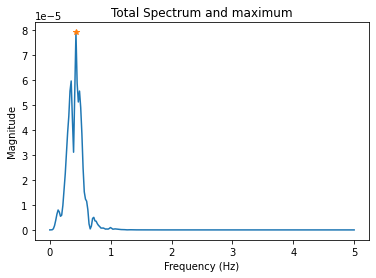

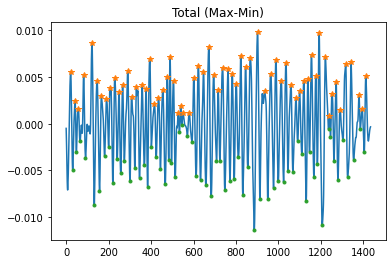

[19.076190476190476, 1.5726410384423364, 1.4977533699450825, 6.676666666666667]
[5.7308055555555555, 0.748876684972541, 0.4867698452321516, 0.13333333333333325]
Wall time: 300 ms


In [19]:
%%time
Max_Ind_T = scipy.signal.find_peaks(SmoothSmoothT, distance=distance_T, prominence=thr_SST)
Max_Ind_T = Max_Ind_T[0]
Maxima_T = SmoothSmoothT[Max_Ind_T]
Min_Ind_T = []
Minima_T = []
for i in range(len(Max_Ind_T)-1):
    min_value = min(SmoothSmoothT[Max_Ind_T[i]:Max_Ind_T[i+1]])
    Minima_T.append(min_value)
    min_index = np.argmin(SmoothSmoothT[Max_Ind_T[i]:Max_Ind_T[i+1]]) + Max_Ind_T[i]
    Min_Ind_T.append(min_index)

# plt.figure(20)
# plt.plot(SmoothSmoothT)
# plt.plot(Max_Ind_T, Maxima_T, linestyle='None', marker='*')
# plt.plot(Min_Ind_T, Minima_T, linestyle='None', marker='.')
# plt.title('Thorax (Max-Min)')

# Respiratory parameters Thorax
T_T = []
Ti_T = []
Te_T = []
TiTe_T = []
fB_T = []
for i in range(len(Min_Ind_T)):
    te = (Min_Ind_T[i] - Max_Ind_T[i]) / fdev
    ti = (Max_Ind_T[i + 1] - Min_Ind_T[i]) / fdev
    Ti_T.append(ti)
    Te_T.append(te)
    ti_te = ti/te
    TiTe_T.append(ti/te)
    ttot = ti + te
    fb = 1/ttot*60
    T_T.append(ttot)
    fB_T.append(fb)

Tmean_T = statistics.mean(T_T)
Timean_T = statistics.mean(Ti_T)
Temean_T = statistics.mean(Te_T)
fBmean_T = statistics.mean(fB_T)
fBspectrum_T = fBspectrum_T*60
TiTemean_T = statistics.mean(TiTe_T)
duty_mean_T = statistics.mean([float(Ti_T/T_T) for Ti_T, T_T in zip(Ti_T, T_T)])

Tstd_T = statistics.stdev(T_T)
Tistd_T = statistics.stdev(Ti_T)
Testd_T = statistics.stdev(Te_T)
fBstd_T = statistics.stdev(fB_T)
TiTestd_T = statistics.stdev(TiTe_T)
duty_std_T = statistics.stdev([float(Ti_T/T_T) for Ti_T, T_T in zip(Ti_T, T_T)])

PCA_T = [fBmean_T, Timean_T, Temean_T, TiTemean_T, duty_mean_T]
SD_T = [fBstd_T, Tistd_T, Testd_T, TiTestd_T, duty_std_T]

# Total
SmoothSmoothTot = SmoothSmoothT+SmoothSmoothA
f_Tot, pxx_Tot = scipy.signal.welch(SmoothSmoothTot, window='hamming', fs=10, nperseg=300, noverlap=50, nfft=512, detrend=False)
start_Tot = np.where(f_Tot > lowThreshold)[0][0] - 1
end_Tot = np.where(f_Tot > f_threshold_max)[0][0]
fBmax_Tot = max(pxx_Tot[start_Tot:end_Tot])

fBI_Tot = np.where(pxx_Tot[start_Tot:end_Tot] == fBmax_Tot)[0][0]
nmax = np.where(f_Tot > 1)[0][0]


plt.figure(21)
plt.plot(f_Tot, pxx_Tot)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.plot(f_Tot[fBI_Tot+start_Tot], fBmax_Tot, marker='*')
plt.title('Total Spectrum and maximum')

fBspectrum_Tot = f_Tot[fBI_Tot+start_Tot]
print(fBspectrum_Tot*60)

if fBspectrum_Tot*60 < 12:
    perc_Tot = 15
    distance_Tot = 35  # min peak distance of 35 frames corresponds to a respiratory rate of 17 resp/min
    SgolayWindow = 15
elif 12 < fBspectrum_Tot*60 < 20:
#else:
    perc_Tot = 8
    distance_Tot = 20  # min peak distance of 20 frames corresponds to a respiratory rate of 30 resp/min
    SgolayWindow = 11
else:
#elif 20 < fBspectrum_Tot*60 < 40:
    perc_Tot = 5
    distance_Tot = 9  # min peak distance of 12 frames corresponds to a frequency rate of 50 resp/min
    SgolayWindow = 9
#elif 40 < fBspectrum_Tot*60 < 59:
#    perc_Tot = 4
#    distance_Tot = 7  # min peak distance of 8 frames correspondsto a respiratory rate of 75 resp/min
#    SgolayWindow = 7
#else:  # fBspectrum_Tot*60 > 59
#    perc_Tot = 3
#    distance_Tot = 3  # min peak distance of 5 frames corresponds to a respiratory rate of 120 resp/min
#    SgolayWindow = 5

diff_SSTot = max(SmoothSmoothTot)-min(SmoothSmoothTot)
thr_SSTot = diff_SSTot*perc_Tot/100

Max_Ind_Tot = scipy.signal.find_peaks(SmoothSmoothTot, distance=distance_Tot, prominence=thr_SSTot)
Max_Ind_Tot = Max_Ind_Tot[0]
Maxima_Tot = SmoothSmoothTot[Max_Ind_Tot]
Min_Ind_Tot = []
Minima_Tot = []
for i in range(len(Max_Ind_Tot)-1):
    min_value = min(SmoothSmoothTot[Max_Ind_Tot[i]:Max_Ind_Tot[i+1]])
    Minima_Tot.append(min_value)
    min_index = np.argmin(SmoothSmoothTot[Max_Ind_Tot[i]:Max_Ind_Tot[i+1]]) + Max_Ind_Tot[i]
    Min_Ind_Tot.append(min_index)

plt.figure(22)
plt.plot(SmoothSmoothTot)
plt.plot(Max_Ind_Tot, Maxima_Tot, linestyle='None', marker='*')
plt.plot(Min_Ind_Tot, Minima_Tot, linestyle='None', marker='.')
plt.title('Total (Max-Min)')

# Respiratory parameters Total
T_Tot = []
Ti_Tot = []
Te_Tot = []
TiTe_Tot = []
fB_Tot = []
VTi_Tot = []
VTe_Tot = []
VT_Tot = []
for i in range(len(Min_Ind_Tot)):
    te = (Min_Ind_Tot[i] - Max_Ind_Tot[i]) / fdev
    ti = (Max_Ind_Tot[i + 1] - Min_Ind_Tot[i]) / fdev
    vti = SmoothSmoothTot[Max_Ind_Tot[i + 1]] - SmoothSmoothTot[Min_Ind_Tot[i]]
    vte = SmoothSmoothTot[Min_Ind_Tot[i]] - SmoothSmoothTot[Max_Ind_Tot[i]]
    vt = (vti+vte)/2
    Ti_Tot.append(ti)
    Te_Tot.append(te)
    ti_te = ti/te
    TiTe_Tot.append(ti/te)
    ttot = ti + te
    fb = 1/ttot*60
    T_Tot.append(ttot)
    fB_Tot.append(fb)
    VTi_Tot.append(vti)
    VTe_Tot.append(vte)
    VT_Tot.append(vt)

Tmean_Tot = statistics.mean(T_Tot)
Timean_Tot = statistics.mean(Ti_Tot)
Temean_Tot = statistics.mean(Te_Tot)
fBmean_Tot = statistics.mean(fB_Tot)
fBspectrum_Tot = fBspectrum_Tot*60
TiTemean_Tot = statistics.mean(TiTe_Tot)
duty_mean_Tot = statistics.mean([float(Ti_Tot/T_Tot) for Ti_Tot, T_Tot in zip(Ti_Tot, T_Tot)])

# Tstd_Tot = statistics.stdev(T_Tot)
# Tistd_Tot = statistics.stdev(Ti_Tot)
# Testd_Tot = statistics.stdev(Te_Tot)
# fBstd_Tot = statistics.stdev(fB_Tot)
# TiTestd_Tot = statistics.stdev(TiTe_Tot)
# duty_std_Tot = statistics.stdev([float(Ti_Tot/T_Tot) for Ti_Tot, T_Tot in zip(Ti_Tot, T_Tot)])

PCA_Tot = [fBmean_Tot, Timean_Tot, Temean_Tot, TiTemean_Tot, duty_mean_Tot]
# SD_Tot = [fBstd_Tot, Tistd_Tot, Testd_Tot, TiTestd_Tot, duty_std_Tot]
plt.show()

#print(PCA_Tot)
Tmed_Tot = statistics.median(T_Tot)
Timed_Tot = statistics.median(Ti_Tot)
Temed_Tot = statistics.median(Te_Tot)
fBmed_Tot = statistics.median(fB_Tot)
fBspectrum_T = fBspectrum_T*60
TiTemed_Tot = statistics.median(TiTe_T)
duty_med_Tot = statistics.median([float(Ti_Tot/T_Tot) for Ti_Tot, T_Tot in zip(Ti_Tot, T_Tot)])
VT_med_Tot = statistics.median(VT_Tot)


Tirq_Tot = stats.iqr(T_Tot)
Tiirq_Tot = stats.iqr(Ti_Tot)
Teirq_Tot = stats.iqr(Te_Tot)
fBirq_Tot = stats.iqr(fB_Tot)
TiTeirq_Tot = stats.iqr(TiTe_Tot)
duty_irq_Tot = stats.iqr([float(Ti_Tot/T_Tot) for Ti_Tot, T_Tot in zip(Ti_Tot, T_Tot)])
#
Tot_med = [fBmed_Tot, Timed_Tot, Temed_Tot,  fdev]
print(Tot_med)
Tot_Iqr = [fBirq_Tot, Tiirq_Tot, Teirq_Tot, duty_irq_Tot]
print(Tot_Iqr)
#
plt.show()
#